In [2]:
# Load libraries
import pandas as pd
import numpy as np
import geopy.distance
import os
import math
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection


In [3]:
k = 0
list_of_df = []

# Loop over every file present in folder "Data\Biotic"
for filename in os.listdir("Data\Biotic"):
       k += 1

       # Read the biotic and accompanying acoustic files
       acoustic_1 = pd.read_csv("Data\\Acoustic\\Acoustic" + filename[6:99], header=0)
       biotic_1 = pd.read_csv("Data\\Biotic\\" + filename, header=0)

       # Filter out the required columns
       a_columns = ['LogTime', 'LogLatitude', 'LogLongitude']
       b_columns = ['HaulStartTime', 'HaulDuration', 'HaulValidity', 'HaulStartLatitude', 'HaulStartLongitude', 'HaulStopLatitude', 'HaulStopLongitude', 'HaulDistance', 'HaulTowDirection']
       acoustic_1_1 = acoustic_1[a_columns]
       biotic_1_1 = biotic_1[b_columns]

       # Set the datetime columns to correct datatype and drop duplicates
       acoustic_1_1['LogTime'] = pd.to_datetime(acoustic_1_1['LogTime'])
       biotic_1_1['HaulStartTime'] = pd.to_datetime(biotic_1_1['HaulStartTime'])
       acoustic_1_1 = acoustic_1_1.drop_duplicates()

       # Prepare the biotic file to have the same structure as the acoustic file
       bio_to_aco = biotic_1_1[['HaulStartTime', 'HaulStartLatitude', 'HaulStartLongitude']]
       bio_to_aco = bio_to_aco.rename(columns={'HaulStartTime': 'LogTime', 'HaulStartLatitude': 'LogLatitude', 'HaulStartLongitude': 'LogLongitude'})

       # Concat the biotic and acoustic file to create a df containing all registered timestamps
       acoustic_final = pd.concat([acoustic_1_1, bio_to_aco], ignore_index=True)
       acoustic_final = acoustic_final.sort_values('LogTime', ignore_index=True)
       acoustic_final['fileIDN'] = k

       # Index both final sets over their respective timestamp columns
       acoustic_final2 = acoustic_final.set_index('LogTime')
       biotic_final = biotic_1_1.set_index('HaulStartTime')

       # Perform final concat adding all available columns to the available timestamps and create new column containing binary classifier for fishing or not.
       full = pd.concat([acoustic_final2, biotic_final], axis=1)
       full['fishing'] = 0
       full.loc[full['HaulValidity'] == 'V', 'fishing'] = 1
       full = full.drop('HaulValidity', axis=1)
       
       # Extend the fishing period (fishing = 1) over all rows that are within the start-end haul timeframe
       # -----------------------------------------------------------------------------------------------------------------------------
       time_str = '1/1/1900 12:00:00.0000'
       date_format_str = '%d/%m/%Y %H:%M:%S.%f'

       track = 1
       start_haul = datetime.strptime(time_str, date_format_str)
       end_haul = datetime.strptime(time_str, date_format_str)
       index = full.index
       while track < full.shape[0]:
              if full['HaulDuration'][track] > 0:
                     start_haul = index[track]
                     end_haul = index[track] + timedelta(minutes=full['HaulDuration'][track])
       
              if index[track] >= start_haul and index[track] <= end_haul:
                     full['fishing'][track] = 1
              track += 1
       # -----------------------------------------------------------------------------------------------------------------------------


       # Calculate speed
       # -----------------------------------------------------------------------------------------------------------------------------
       full = full[['LogLatitude', 'LogLongitude', 'fishing', 'fileIDN', ]]
       distances = [0]
       durations = [0]
       index = full.index
       i=0
       while i < full.shape[0] - 1:
              distances.append(geopy.distance.distance((full['LogLatitude'][i], full['LogLongitude'][i]), (full['LogLatitude'][i+1], full['LogLongitude'][i+1])).km)
              durations.append((index[i+1] - index[i]).total_seconds())
              i += 1

       km_s = [0]
       j=1
       while j < len(distances):
              if durations[j] != 0:
                     km_s.append((distances[j]/durations[j]) * 60 * 60)
              else:
                     km_s.append(0)
              j += 1

       full['speed'] = km_s
       # -----------------------------------------------------------------------------------------------------------------------------


       # Calculate speeds based on lag/lead
       # -----------------------------------------------------------------------------------------------------------------------------
       speed_lag_1 = []
       speed_lead_1 = []
       speed_both_1 = []
       speed_lag_2 = []
       speed_lead_2 = []
       speed_both_2 = []

       full['lag_1'] = full['speed'].shift(1)
       full['lag_2'] = full['speed'].shift(2)
       full['lead_1'] = full['speed'].shift(-1)
       full['lead_2'] = full['speed'].shift(-2)

       m = 0
       while m < full.shape[0]:
              speed_current = full['speed'][m]
              lag_1 = full['lag_1'][m]
              lag_2 = full['lag_2'][m]
              lead_1 = full['lead_1'][m]
              lead_2 = full['lead_2'][m]

              if math.isnan(lag_1):
                     average_speed_lg1 = speed_current
              else:
                     average_speed_lg1 = (speed_current + lag_1) / 2
              
              if math.isnan(lag_2) and math.isnan(lag_1):
                     average_speed_lg2 = speed_current
              elif math.isnan(lag_2) and not math.isnan(lag_1):
                     average_speed_lg2 = (speed_current + lag_1) / 2
              else:
                     average_speed_lg2 = (speed_current + lag_1 + lag_2) / 3
              
              if math.isnan(lead_1):
                     average_speed_ld1 = speed_current
              else:
                     average_speed_ld1 = (speed_current + lead_1) / 2
              
              if math.isnan(lead_2) and math.isnan(lead_1):
                     average_speed_ld2 = speed_current
              elif math.isnan(lead_2) and not math.isnan(lead_1):
                     average_speed_ld2 = (speed_current + lead_1) / 2
              else:
                     average_speed_ld2 = (speed_current + lead_1 + lead_2) / 3
              
              if math.isnan(lead_1):
                     average_speed_b1 = (speed_current + lag_1) / 2
              elif math.isnan(lag_1):
                     average_speed_b1 = (speed_current + lead_1) / 2
              else:
                     average_speed_b1 = (speed_current + lead_1 + lag_1) / 3
              
              if math.isnan(lead_1):
                     average_speed_b2 = (speed_current + lag_1 + lag_2) / 3
              elif math.isnan(lead_2):
                     average_speed_b2 = (speed_current + lag_1 + lag_2 + lead_1) / 4
              elif math.isnan(lag_1):
                     average_speed_b2 = (speed_current + lead_1 + lead_2) / 3
              elif math.isnan(lag_2):
                     average_speed_b2 = (speed_current + lead_1 + lead_2 + lag_1) / 4
              else:
                     average_speed_b2 = (speed_current + lead_1 + lag_1 + lead_2 + lag_2) / 5

              speed_lag_1.append(average_speed_lg1)
              speed_lag_2.append(average_speed_lg2)
              speed_lead_1.append(average_speed_ld1)
              speed_lead_2.append(average_speed_ld2)
              speed_both_1.append(average_speed_b1)
              speed_both_2.append(average_speed_b2)
              
              m += 1

       full['speed_lag_1'] = speed_lag_1
       full['speed_lag_2'] = speed_lag_2
       full['speed_lead_1'] = speed_lead_1
       full['speed_lead_2'] = speed_lead_2
       full['speed_both_1'] = speed_both_1
       full['speed_both_2'] = speed_both_2
       # -----------------------------------------------------------------------------------------------------------------------------


       # Calculate direction based on previous and next
       # -----------------------------------------------------------------------------------------------------------------------------
       # Create lag and lead of lat/long
       full['lat_f1'] = full['LogLatitude'].shift(-1) # latitude with lead 1
       full['lon_f1'] = full['LogLongitude'].shift(-1) # Longtitude with lead 1
       full['lat_b1'] = full['LogLatitude'].shift(1) # latitude with lag 1
       full['lon_b1'] = full['LogLongitude'].shift(1) # Longtitude with lag 1

       direction = [0]
       geo_track = 1
       while geo_track < full.shape[0]:
              delta_lon = full['LogLongitude'][geo_track] - full['lon_b1'][geo_track]
              y2 = math.sin(delta_lon) * math.cos(full['LogLatitude'][geo_track])
              x2 = math.cos(full['lat_b1'][geo_track]) * math.sin(full['LogLatitude'][geo_track]) - math.sin(full['lat_b1'][geo_track]) * math.cos(full['LogLatitude'][geo_track]) * math.cos(delta_lon)

              brng2 = math.atan2(y2, x2)
              brng2 = math.degrees(brng2)

              direction.append(brng2)

              geo_track += 1

       full['bearing'] = direction

       direction_change = [0, 0]
       geo_track2 = 2
       while geo_track2 < full.shape[0]:
              change = full['bearing'][geo_track2 - 1] - full['bearing'][geo_track2]
              direction_change.append(change)

              geo_track2 += 1

       full['bearing change'] = direction_change
       # -----------------------------------------------------------------------------------------------------------------------------

       list_of_df.append(full) # Add calculated df to list of lists to be transformed back to a final df at the end

full_set = pd.concat(list_of_df,ignore_index=False) # transform list of lists to final df

C:\Users\MarkR\AppData\Local\Temp\ipykernel_2080\1468388211.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acoustic_1_1['LogTime'] = pd.to_datetime(acoustic_1_1['LogTime'])
C:\Users\MarkR\AppData\Local\Temp\ipykernel_2080\1468388211.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biotic_1_1['HaulStartTime'] = pd.to_datetime(biotic_1_1['HaulStartTime'])
C:\Users\MarkR\AppData\Local\Temp\ipykernel_2080\1468388211.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [21]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(full_set.loc[full_set['fileIDN'] == 1])

,LogLatitude,LogLongitude,fishing,fileIDN,speed,lag_1,lag_2,lead_1,lead_2,speed_lag_1,speed_lag_2,speed_lead_1,speed_lead_2,speed_both_1,speed_both_2,lat_f1,lon_f1,lat_b1,lon_b1,bearing,bearing change
2021-07-01 04:23:00,55.895245,6.030530,0,1,0.000000,NaN,NaN,18.573427,18.623732,0.000000,0.000000,9.286714,12.399053,9.286714,12.399053,55.895240,6.060218,NaN,NaN,0.000000,0.000000
2021-07-01 04:29:00,55.895240,6.060218,0,1,18.573427,0.000000,NaN,18.623732,18.636269,9.286714,9.286714,18.598580,18.611143,12.399053,13.958357,55.895256,6.089987,55.895245,6.030530,90.529208,0.000000
2021-07-01 04:35:00,55.895256,6.089987,0,1,18.623732,18.573427,0.000000,18.636269,18.589848,18.598580,12.399053,18.630001,18.616616,18.611143,14.884655,55.895140,6.119775,55.895240,6.060218,90.479671,0.049537
2021-07-01 04:41:00,55.895140,6.119775,0,1,18.636269,18.623732,18.573427,18.589848,22.338484,18.630001,18.611143,18.613059,19.854867,18.616616,19.352352,55.895180,6.149489,55.895256,6.089987,90.799815,-0.320144
2021-07-01 04:47:00,55.895180,6.149489,0,1,18.589848,18.636269,18.623732,22.338484,18.599033,18.613059,18.616616,20.464166,19.842455,19.854867,19.357473,55.895252,6.179245,55.895140,6.119775,90.420428,0.379386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19 15:33:00,54.786050,5.853586,0,1,18.491685,18.517347,18.561051,18.564471,22.173167,18.504516,18.523361,18.528078,19.743108,18.524501,19.261544,54.786130,5.882442,54.786110,5.824843,-89.819050,1.046210
2021-07-19 15:39:00,54.786130,5.882442,0,1,18.564471,18.491685,18.517347,22.173167,18.521385,18.528078,18.524501,20.368819,19.753008,19.743108,19.253611,54.785970,5.911162,54.786050,5.853586,-88.355242,-1.463809
2021-07-19 15:44:00,54.785970,5.911162,0,1,22.173167,18.564471,18.491685,18.521385,18.498599,20.368819,19.743108,20.347276,19.731050,19.753008,19.249861,54.786130,5.939950,54.786130,5.882442,-90.866008,2.510767
2021-07-19 15:50:00,54.786130,5.939950,0,1,18.521385,22.173167,18.564471,18.498599,NaN,20.347276,19.753008,18.509992,18.509992,19.731050,19.439406,54.786270,5.968703,54.785970,5.911162,-87.520674,-3.345335


In [4]:
full_set.to_csv('Data/full_set.csv', index_label='timestamp')
# display(full_set)

In [5]:
full_set.reset_index(inplace=True)
full_set.head()

,index,LogLatitude,LogLongitude,fishing,fileIDN,speed,lag_1,lag_2,lead_1,lead_2,...,speed_lead_1,speed_lead_2,speed_both_1,speed_both_2,lat_f1,lon_f1,lat_b1,lon_b1,bearing,bearing change
0,2021-07-01 04:23:00,55.895245,6.030530,0,1,0.000000,NaN,NaN,18.573427,18.623732,...,9.286714,12.399053,9.286714,12.399053,55.895240,6.060218,NaN,NaN,0.000000,0.000000
1,2021-07-01 04:29:00,55.895240,6.060218,0,1,18.573427,0.000000,NaN,18.623732,18.636269,...,18.598580,18.611143,12.399053,13.958357,55.895256,6.089987,55.895245,6.030530,90.529208,0.000000
2,2021-07-01 04:35:00,55.895256,6.089987,0,1,18.623732,18.573427,0.000000,18.636269,18.589848,...,18.630001,18.616616,18.611143,14.884655,55.895140,6.119775,55.895240,6.060218,90.479671,0.049537
3,2021-07-01 04:41:00,55.895140,6.119775,0,1,18.636269,18.623732,18.573427,18.589848,22.338484,...,18.613059,19.854867,18.616616,19.352352,55.895180,6.149489,55.895256,6.089987,90.799815,-0.320144
4,2021-07-01 04:47:00,55.895180,6.149489,0,1,18.589848,18.636269,18.623732,22.338484,18.599033,...,20.464166,19.842455,19.854867,19.357473,55.895252,6.179245,55.895140,6.119775,90.420428,0.379386


In [6]:
# rename columns
full_set = full_set.rename(columns={"index": "datetimestamp"})

# convert datetime to int
full_set['int_datetime'] =  full_set['datetimestamp'].astype('int64')

full_set.head()

,datetimestamp,LogLatitude,LogLongitude,fishing,fileIDN,speed,lag_1,lag_2,lead_1,lead_2,...,speed_lead_2,speed_both_1,speed_both_2,lat_f1,lon_f1,lat_b1,lon_b1,bearing,bearing change,int_datetime
0,2021-07-01 04:23:00,55.895245,6.030530,0,1,0.000000,NaN,NaN,18.573427,18.623732,...,12.399053,9.286714,12.399053,55.895240,6.060218,NaN,NaN,0.000000,0.000000,1625113380000000000
1,2021-07-01 04:29:00,55.895240,6.060218,0,1,18.573427,0.000000,NaN,18.623732,18.636269,...,18.611143,12.399053,13.958357,55.895256,6.089987,55.895245,6.030530,90.529208,0.000000,1625113740000000000
2,2021-07-01 04:35:00,55.895256,6.089987,0,1,18.623732,18.573427,0.000000,18.636269,18.589848,...,18.616616,18.611143,14.884655,55.895140,6.119775,55.895240,6.060218,90.479671,0.049537,1625114100000000000
3,2021-07-01 04:41:00,55.895140,6.119775,0,1,18.636269,18.623732,18.573427,18.589848,22.338484,...,19.854867,18.616616,19.352352,55.895180,6.149489,55.895256,6.089987,90.799815,-0.320144,1625114460000000000
4,2021-07-01 04:47:00,55.895180,6.149489,0,1,18.589848,18.636269,18.623732,22.338484,18.599033,...,19.842455,19.854867,19.357473,55.895252,6.179245,55.895140,6.119775,90.420428,0.379386,1625114820000000000


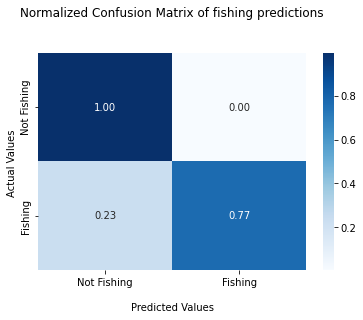

In [7]:
'''
full_x = full_set[['speed', 'speed_lead_1']]
full_y = full_set['fishing']

# rus = RandomUnderSampler() 
# full_x, full_y = rus.fit_resample(full_set[['speed']], full_set['fishing'])
print(Counter(full_y))

X_train = full_x.head(round(full_x.shape[0]*0.7))

y_train = full_y.head(round(len(full_y)*0.7))

X_test = full_x.tail(round(full_x.shape[0]*0.3))
y_test = full_y.tail(round(len(full_y)*0.3))
'''

full_x = full_set[['int_datetime', 'LogLatitude', 'LogLongitude', 'speed', 'speed_lead_1']]
full_y = full_set['fishing']

X_train, X_test, y_train, y_test = train_test_split(full_x, full_y, random_state=899370109, test_size=0.3)

clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred)
# normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')

ax.set_title('Normalized Confusion Matrix of fishing predictions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not Fishing','Fishing'])
ax.yaxis.set_ticklabels(['Not Fishing','Fishing'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [12]:
full_test = X_test
full_test['y_test'] = y_test.tolist()
full_test['y_pred'] = y_pred
y_proba = pd.DataFrame(y_proba)
full_test['y_proba 0'] = y_proba[0].tolist()
full_test['y_proba 1'] = y_proba[1].tolist()

C:\Users\Suryashree\AppData\Local\Temp\ipykernel_17856\592133877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_test['y_test'] = y_test.tolist()
C:\Users\Suryashree\AppData\Local\Temp\ipykernel_17856\592133877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_test['y_pred'] = y_pred
C:\Users\Suryashree\AppData\Local\Temp\ipykernel_17856\592133877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(full_test)

In [8]:
oman_1 = pd.read_csv("Data/Oman_AIS/raw_ais_20210501_20220531_461000002.txt", sep="\t", header=0)
oman_1['Timestamp'] = pd.to_datetime(oman_1['Timestamp'])
oman_1 = oman_1[['Timestamp', 'Latitude', 'Longitude']]
oman_1 = oman_1.sort_values(by='Timestamp', ignore_index=True)
oman_1 = oman_1.set_index('Timestamp').rename_axis(None)
oman_1.columns = ['LogLatitude', 'LogLongitude']
oman_1 = oman_1.dropna()

display(oman_1)

,LogLatitude,LogLongitude
2021-05-01 01:11:24,20.99134,59.45736
2021-05-01 02:05:24,21.10693,59.49646
2021-05-01 02:08:44,21.11462,59.49598
2021-05-01 02:37:04,21.08519,59.49337
2021-05-01 02:45:30,21.06769,59.48729
...,...,...
2022-05-29 17:35:00,19.67523,57.72517
2022-05-29 18:56:05,19.67520,57.72515
2022-05-31 00:20:07,19.67522,57.72517
2022-05-31 02:29:05,19.67522,57.72515


In [9]:
# display(oman_1.loc[oman_1.index > "2021-05-02 17:33:41"])
display(oman_1.loc[oman_1['LogLatitude'].isnull()])

,LogLatitude,LogLongitude


In [10]:
full = oman_1
distances = [0]
durations = [0]
index = full.index
i=0
while i < full.shape[0] - 1:
        # print(str(index[i]) + str(full['LogLatitude'][i]) + str(full['LogLongitude'][i]))
        distances.append(geopy.distance.distance((full['LogLatitude'][i], full['LogLongitude'][i]), (full['LogLatitude'][i+1], full['LogLongitude'][i+1])).km)
        durations.append((index[i+1] - index[i]).total_seconds())
        i += 1

km_s = [0]
j=1
while j < len(distances):
        if durations[j] != 0:
                km_s.append((distances[j]/durations[j]) * 60 * 60)
        else:
                km_s.append(0)
        j += 1

full['speed'] = km_s
# -----------------------------------------------------------------------------------------------------------------------------


# Calculate speeds based on lag/lead
# -----------------------------------------------------------------------------------------------------------------------------
speed_lag_1 = []
speed_lead_1 = []
speed_both_1 = []
speed_lag_2 = []
speed_lead_2 = []
speed_both_2 = []

full['lag_1'] = full['speed'].shift(1)
full['lag_2'] = full['speed'].shift(2)
full['lead_1'] = full['speed'].shift(-1)
full['lead_2'] = full['speed'].shift(-2)

m = 0
while m < full.shape[0]:
        speed_current = full['speed'][m]
        lag_1 = full['lag_1'][m]
        lag_2 = full['lag_2'][m]
        lead_1 = full['lead_1'][m]
        lead_2 = full['lead_2'][m]

        if math.isnan(lag_1):
                average_speed_lg1 = speed_current
        else:
                average_speed_lg1 = (speed_current + lag_1) / 2
        
        if math.isnan(lag_2) and math.isnan(lag_1):
                average_speed_lg2 = speed_current
        elif math.isnan(lag_2) and not math.isnan(lag_1):
                average_speed_lg2 = (speed_current + lag_1) / 2
        else:
                average_speed_lg2 = (speed_current + lag_1 + lag_2) / 3
        
        if math.isnan(lead_1):
                average_speed_ld1 = speed_current
        else:
                average_speed_ld1 = (speed_current + lead_1) / 2
        
        if math.isnan(lead_2) and math.isnan(lead_1):
                average_speed_ld2 = speed_current
        elif math.isnan(lead_2) and not math.isnan(lead_1):
                average_speed_ld2 = (speed_current + lead_1) / 2
        else:
                average_speed_ld2 = (speed_current + lead_1 + lead_2) / 3
        
        if math.isnan(lead_1):
                average_speed_b1 = (speed_current + lag_1) / 2
        elif math.isnan(lag_1):
                average_speed_b1 = (speed_current + lead_1) / 2
        else:
                average_speed_b1 = (speed_current + lead_1 + lag_1) / 3
        
        if math.isnan(lead_1):
                average_speed_b2 = (speed_current + lag_1 + lag_2) / 3
        elif math.isnan(lead_2):
                average_speed_b2 = (speed_current + lag_1 + lag_2 + lead_1) / 4
        elif math.isnan(lag_1):
                average_speed_b2 = (speed_current + lead_1 + lead_2) / 3
        elif math.isnan(lag_2):
                average_speed_b2 = (speed_current + lead_1 + lead_2 + lag_1) / 4
        else:
                average_speed_b2 = (speed_current + lead_1 + lag_1 + lead_2 + lag_2) / 5

        speed_lag_1.append(average_speed_lg1)
        speed_lag_2.append(average_speed_lg2)
        speed_lead_1.append(average_speed_ld1)
        speed_lead_2.append(average_speed_ld2)
        speed_both_1.append(average_speed_b1)
        speed_both_2.append(average_speed_b2)
        
        m += 1

full['speed_lag_1'] = speed_lag_1
full['speed_lag_2'] = speed_lag_2
full['speed_lead_1'] = speed_lead_1
full['speed_lead_2'] = speed_lead_2
full['speed_both_1'] = speed_both_1
full['speed_both_2'] = speed_both_2
# -----------------------------------------------------------------------------------------------------------------------------


# Calculate direction based on previous and next
# -----------------------------------------------------------------------------------------------------------------------------
# Create lag and lead of lat/long
full['lat_f1'] = full['LogLatitude'].shift(-1) # latitude with lead 1
full['lon_f1'] = full['LogLongitude'].shift(-1) # Longtitude with lead 1
full['lat_b1'] = full['LogLatitude'].shift(1) # latitude with lag 1
full['lon_b1'] = full['LogLongitude'].shift(1) # Longtitude with lag 1

direction = [0]
geo_track = 1
while geo_track < full.shape[0]:
        delta_lon = full['LogLongitude'][geo_track] - full['lon_b1'][geo_track]
        y2 = math.sin(delta_lon) * math.cos(full['LogLatitude'][geo_track])
        x2 = math.cos(full['lat_b1'][geo_track]) * math.sin(full['LogLatitude'][geo_track]) - math.sin(full['lat_b1'][geo_track]) * math.cos(full['LogLatitude'][geo_track]) * math.cos(delta_lon)

        brng2 = math.atan2(y2, x2)
        brng2 = math.degrees(brng2)

        direction.append(brng2)

        geo_track += 1

full['bearing'] = direction

direction_change = [0, 0]
geo_track2 = 2
while geo_track2 < full.shape[0]:
        change = full['bearing'][geo_track2 - 1] - full['bearing'][geo_track2]
        direction_change.append(change)

        geo_track2 += 1

full['bearing change'] = direction_change
# -----------------------------------------------------------------------------------------------------------------------------

In [11]:
full.reset_index(inplace=True)

# rename columns
full = full.rename(columns={"index": "datetimestamp"})

# convert datetime to int
full['int_datetime'] =  full['datetimestamp'].astype('int64')

display(full)

,datetimestamp,LogLatitude,LogLongitude,speed,lag_1,lag_2,lead_1,lead_2,speed_lag_1,speed_lag_2,...,speed_lead_2,speed_both_1,speed_both_2,lat_f1,lon_f1,lat_b1,lon_b1,bearing,bearing change,int_datetime
0,2021-05-01 01:11:24,20.99134,59.45736,0.000000,NaN,NaN,14.919556,15.351916,0.000000,0.000000,...,10.090491,7.459778,10.090491,21.10693,59.49646,NaN,NaN,0.000000,0.000000,1619831484000000000
1,2021-05-01 02:05:24,21.10693,59.49646,14.919556,0.000000,NaN,15.351916,6.924082,7.459778,7.459778,...,12.398518,10.090491,9.298889,21.11462,59.49598,20.99134,59.45736,-12.167251,0.000000,1619834724000000000
2,2021-05-01 02:08:44,21.11462,59.49598,15.351916,14.919556,0.000000,6.924082,14.499446,15.135736,10.090491,...,12.258481,12.398518,10.339000,21.08519,59.49337,21.10693,59.49646,2.287041,-14.454292,1619834924000000000
3,2021-05-01 02:37:04,21.08519,59.49337,6.924082,15.351916,14.919556,14.499446,1.462610,11.137999,12.398518,...,7.628713,12.258481,10.631522,21.06769,59.48729,21.11462,59.49598,176.868047,-174.581005,1619836624000000000
4,2021-05-01 02:45:30,21.06769,59.48729,14.499446,6.924082,15.351916,1.462610,16.928057,10.711764,12.258481,...,10.963371,7.628713,11.033222,21.07503,59.48908,21.08519,59.49337,168.171702,8.696345,1619837130000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,2022-05-29 17:35:00,19.67523,57.72517,0.000000,0.000208,0.000212,0.002906,0.000104,0.000104,0.000140,...,0.001003,0.001038,0.000686,19.67520,57.72515,19.67523,57.72517,0.000000,89.999579,1653845700000000000
13278,2022-05-29 18:56:05,19.67520,57.72515,0.002906,0.000000,0.000208,0.000104,0.000976,0.001453,0.001038,...,0.001329,0.001003,0.000839,19.67522,57.72517,19.67523,57.72517,-155.674305,155.674305,1653850565000000000
13279,2022-05-31 00:20:07,19.67522,57.72517,0.000104,0.002906,0.000000,0.000976,0.000316,0.001505,0.001003,...,0.000465,0.001329,0.000860,19.67522,57.72515,19.67520,57.72515,34.139847,-189.814152,1653956407000000000
13280,2022-05-31 02:29:05,19.67522,57.72515,0.000976,0.000104,0.002906,0.000316,NaN,0.000540,0.001329,...,0.000646,0.000465,0.001076,19.67523,57.72513,19.67522,57.72517,-89.999579,124.139426,1653964145000000000


In [12]:
full_x = full[['int_datetime', 'LogLatitude', 'LogLongitude', 'speed', 'speed_lead_1']]
y_pred = clf.predict(full_x)
y_proba = clf.predict_proba(full_x)

In [100]:
full_test = full_x
full_test['y_pred'] = y_pred
y_proba = pd.DataFrame(y_proba)
full_test['y_proba 0'] = y_proba[0].tolist()
full_test['y_proba 1'] = y_proba[1].tolist()

full_test['LogLongitude_2'] = full_test['LogLongitude'].shift(-1)
full_test['LogLatitude_2'] = full_test['LogLatitude'].shift(-1)

display(full_test)

fish_loc = full_test.loc[full_test['y_pred'] == 1]
fish_loc = fish_loc[['LogLatitude', 'LogLongitude']]
display(fish_loc)

C:\Users\MarkR\AppData\Local\Temp\ipykernel_2080\3838367615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_test['y_pred'] = y_pred
C:\Users\MarkR\AppData\Local\Temp\ipykernel_2080\3838367615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_test['y_proba 0'] = y_proba[0].tolist()
C:\Users\MarkR\AppData\Local\Temp\ipykernel_2080\3838367615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,int_datetime,LogLatitude,LogLongitude,speed,speed_lead_1,y_pred,y_proba 0,y_proba 1,LogLongitude_2,LogLatitude_2
0,1619831484000000000,20.99134,59.45736,0.000000,7.459778,0,0.60,0.40,59.49646,21.10693
1,1619834724000000000,21.10693,59.49646,14.919556,15.135736,0,1.00,0.00,59.49598,21.11462
2,1619834924000000000,21.11462,59.49598,15.351916,11.137999,0,0.98,0.02,59.49337,21.08519
3,1619836624000000000,21.08519,59.49337,6.924082,10.711764,0,0.96,0.04,59.48729,21.06769
4,1619837130000000000,21.06769,59.48729,14.499446,7.981028,0,0.85,0.15,59.48908,21.07503
...,...,...,...,...,...,...,...,...,...,...
13277,1653845700000000000,19.67523,57.72517,0.000000,0.001453,0,0.53,0.47,57.72515,19.67520
13278,1653850565000000000,19.67520,57.72515,0.002906,0.001505,0,0.53,0.47,57.72517,19.67522
13279,1653956407000000000,19.67522,57.72517,0.000104,0.000540,0,0.53,0.47,57.72515,19.67522
13280,1653964145000000000,19.67522,57.72515,0.000976,0.000646,0,0.53,0.47,57.72513,19.67523


,LogLatitude,LogLongitude
9,21.05103,59.48160
10,21.14047,59.51361
11,21.09151,59.49372
41,21.08141,59.50336
43,21.14328,59.51942
...,...,...
12955,19.67628,57.72538
12956,19.67630,57.72540
13001,19.67630,57.72537
13084,19.67632,57.72538


c:\Users\MarkR\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
88,3424386,Asia,Oman,OMN,173100.0,"MULTIPOLYGON (((55.20834 22.70833, 55.23449 23..."


c:\Users\MarkR\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\MarkR\AppData\Local\Programs\Python\Python39\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<AxesSubplot:>

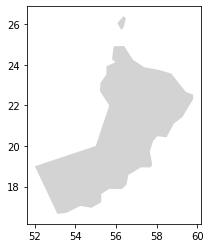

In [86]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
display(countries.loc[countries['name'] == "Oman"])
countries[countries["name"] == "Oman"].plot(color="lightgrey")

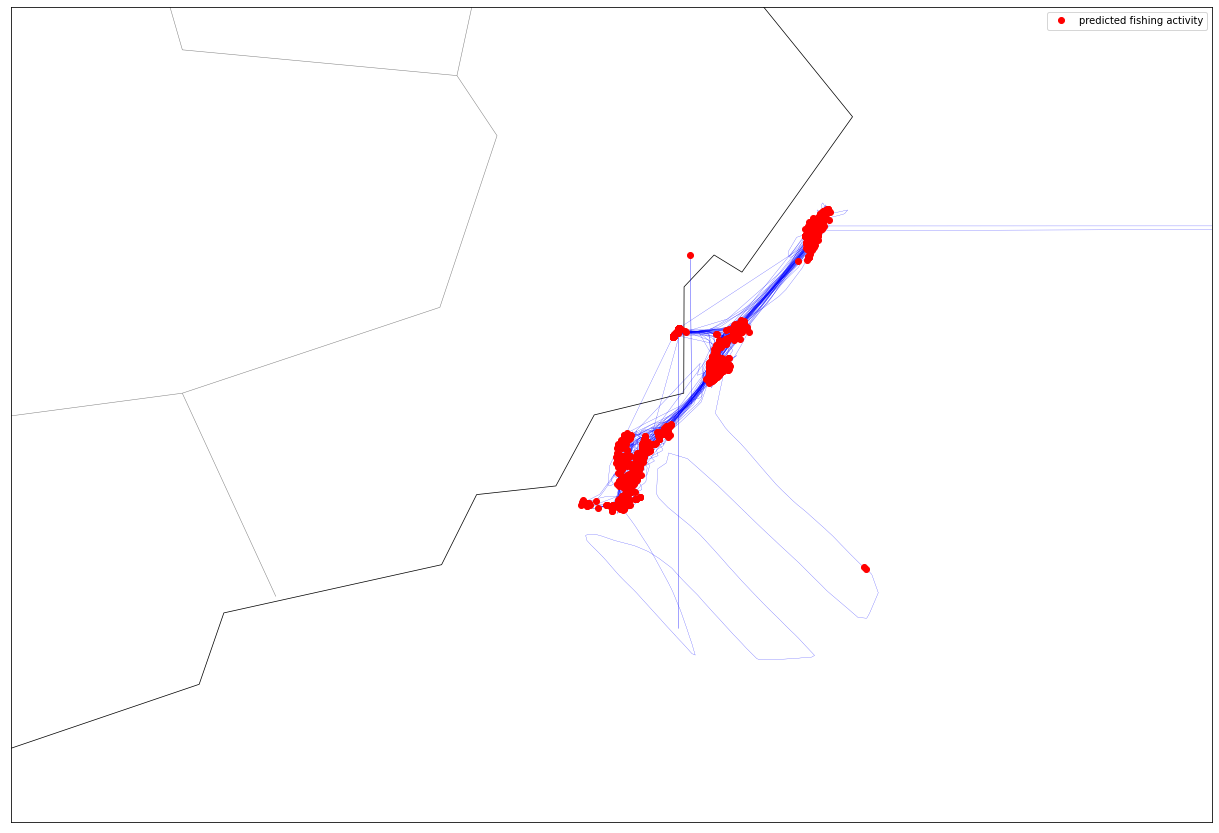

In [111]:
# m = Basemap(llcrnrlon=-35,llcrnrlat=45,urcrnrlon=25,urcrnrlat=80, lat_0 = -5, lon_0 = 62.5)
plt.figure(figsize=(25,15))
m = Basemap(lat_0 = -5, lon_0 = 62.5, llcrnrlon=50, llcrnrlat=14, urcrnrlon=64, urcrnrlat=23.5)

m.drawcoastlines(linewidth=0.72, color='black')
m.drawcountries(zorder=0, color='gray')

lon1, lat1 = m(full_test.LogLongitude.values, full_test.LogLatitude.values)
lon2, lat2 = m(full_test.LogLongitude_2.values, full_test.LogLatitude_2.values)
lon_f, lat_f = m(fish_loc.LogLongitude.values, fish_loc.LogLatitude.values)

pts = np.c_[lon1, lat1, lon2, lat2].reshape(len(lon1), 2, 2)
plt.gca().add_collection(LineCollection(pts, linewidths=0.2, color="blue"))

# m.plot(lon1, lat1, linewidth=0.2)
# m.plot(lon2, lat2, linewidth=0.2)
m.plot(lon_f, lat_f, marker='o', ls="", linewidth=0.4, color="red", label="predicted fishing activity")

plt.legend()
plt.show()

In [104]:
print(full_set['LogLatitude'].min())
print(full_set['LogLongitude'].min())
print(full_set['LogLatitude'].max())
print(full_set['LogLongitude'].max())
display(full_set)

51.078
-30.673
76.7225
20.033985


,datetimestamp,LogLatitude,LogLongitude,fishing,fileIDN,speed,lag_1,lag_2,lead_1,lead_2,...,speed_lead_2,speed_both_1,speed_both_2,lat_f1,lon_f1,lat_b1,lon_b1,bearing,bearing change,int_datetime
0,2021-07-01 04:23:00,55.895245,6.030530,0,1,0.000000,NaN,NaN,18.573427,18.623732,...,12.399053,9.286714,12.399053,55.895240,6.060218,NaN,NaN,0.000000,0.000000,1625113380000000000
1,2021-07-01 04:29:00,55.895240,6.060218,0,1,18.573427,0.000000,NaN,18.623732,18.636269,...,18.611143,12.399053,13.958357,55.895256,6.089987,55.895245,6.030530,90.529208,0.000000,1625113740000000000
2,2021-07-01 04:35:00,55.895256,6.089987,0,1,18.623732,18.573427,0.000000,18.636269,18.589848,...,18.616616,18.611143,14.884655,55.895140,6.119775,55.895240,6.060218,90.479671,0.049537,1625114100000000000
3,2021-07-01 04:41:00,55.895140,6.119775,0,1,18.636269,18.623732,18.573427,18.589848,22.338484,...,19.854867,18.616616,19.352352,55.895180,6.149489,55.895256,6.089987,90.799815,-0.320144,1625114460000000000
4,2021-07-01 04:47:00,55.895180,6.149489,0,1,18.589848,18.636269,18.623732,22.338484,18.599033,...,19.842455,19.854867,19.357473,55.895252,6.179245,55.895140,6.119775,90.420428,0.379386,1625114820000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52329,2022-04-02 03:50:00,58.773000,-7.611000,0,19,18.513005,22.255465,18.545690,22.376517,22.257376,...,21.048966,21.048329,20.789610,58.771000,-7.579000,58.773000,-7.643000,-90.727853,-2.939868,1648871400000000000
52330,2022-04-02 03:55:00,58.771000,-7.579000,0,19,22.376517,18.513005,22.255465,22.257376,22.258013,...,22.297302,21.048966,21.532075,58.770000,-7.547000,58.773000,-7.611000,-96.604723,5.876870,1648871700000000000
52331,2022-04-02 04:00:00,58.770000,-7.547000,0,19,22.257376,22.376517,18.513005,22.258013,27.823313,...,24.112901,22.297302,22.645645,58.769000,-7.515000,58.771000,-7.579000,-93.680934,-2.923789,1648872000000000000
52332,2022-04-02 04:05:00,58.769000,-7.515000,0,19,22.258013,22.257376,22.376517,27.823313,NaN,...,25.040663,24.112901,23.678805,58.768000,-7.483000,58.770000,-7.547000,-93.685363,0.004429,1648872300000000000
